<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/deepseek_enhanced_model_rendom_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap
!pip install lime
!pip install optuna
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e024002e19d5ebf82b6cd773ef7b59beefe8d2e2ac179bcb60fe9fd5eaf44d6b
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 16.5 MB/s eta 0:00:00



=== Correlation of each feature with 'dropout' (descending) ===
dropout              1.000000
day_30_wiki         -0.015062
day_20_wiki         -0.019370
day_28_wiki         -0.022138
day_29_wiki         -0.024976
day_27_wiki         -0.025108
day_11_wiki         -0.030351
day_17_wiki         -0.031673
day_21_wiki         -0.032608
day_22_wiki         -0.034441
day_25_wiki         -0.036512
day_24_wiki         -0.036938
day_26_wiki         -0.037370
day_5_wiki          -0.038532
day_10_wiki         -0.040052
day_23_wiki         -0.042845
day_30_discussion   -0.042918
day_13_wiki         -0.043419
day_12_wiki         -0.043437
day_9_wiki          -0.044936
day_19_wiki         -0.047172
day_6_wiki          -0.050100
day_14_wiki         -0.051187
day_16_wiki         -0.052112
day_18_wiki         -0.052178
day_8_wiki          -0.053144
day_4_wiki          -0.054380
day_20_discussion   -0.056613
day_27_discussion   -0.056864
day_2_wiki          -0.057057
day_3_wiki          -0.057069
day_7

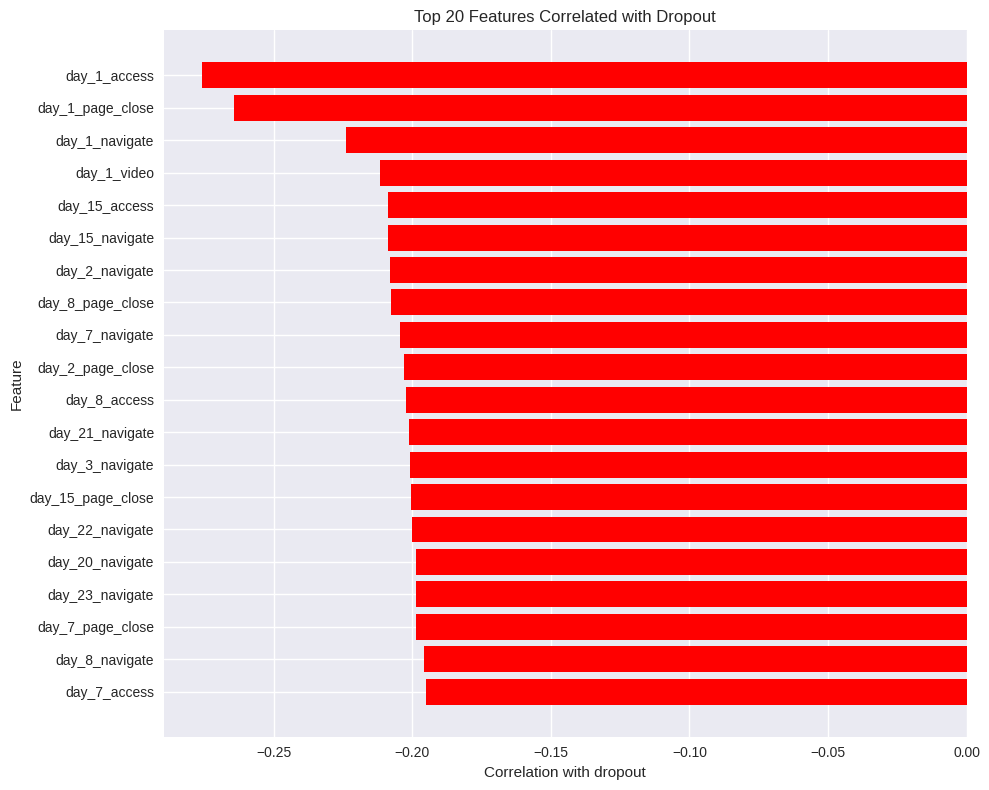

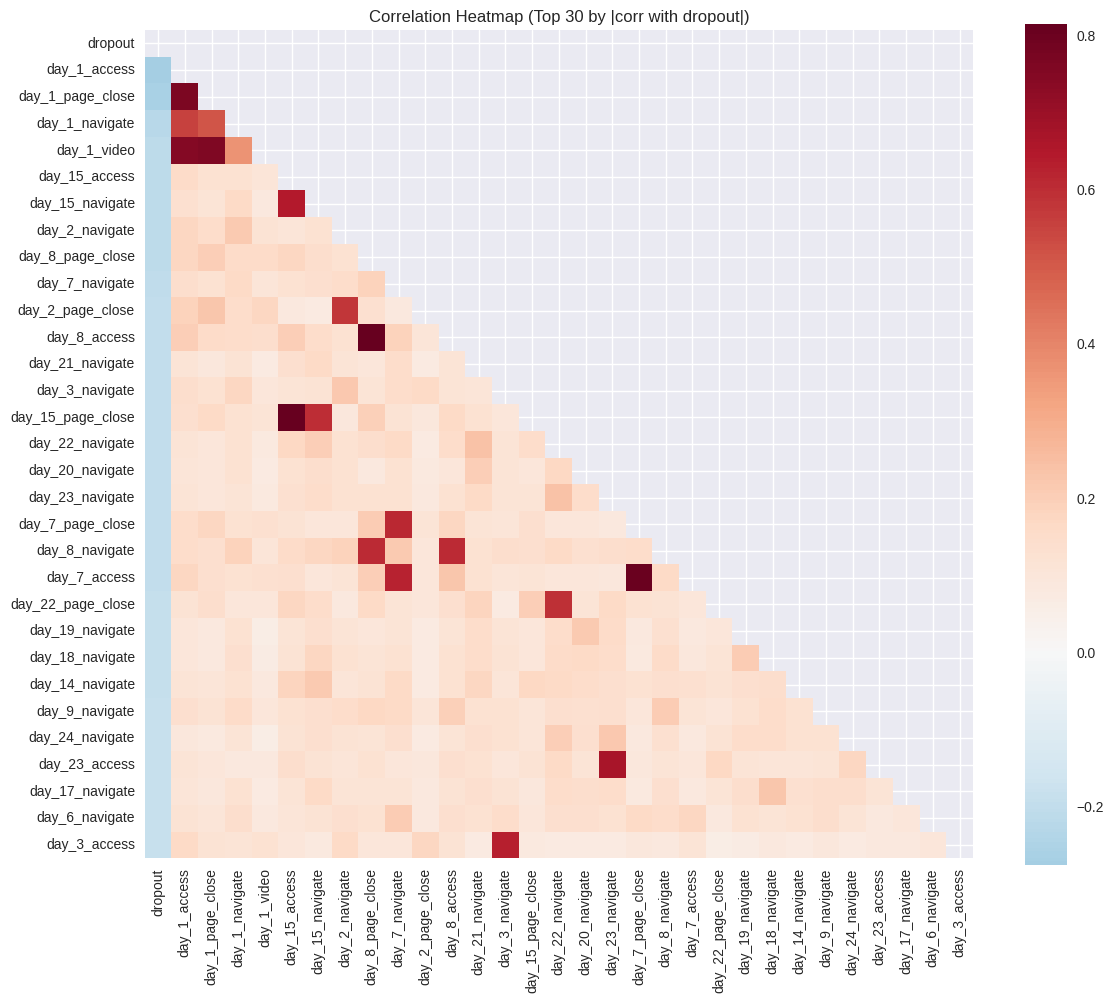


=== Training Random Forest with Original technique ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Original:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'class_weight': None, 'bootstrap': True}

=== Random Forest with Original Test Metrics ===
Accuracy : 0.8593
Precision: 0.8762
Recall   : 0.9579
F1 Score : 0.9152
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

 Not Dropout       0.75      0.48      0.59      4992
     Dropout       0.88      0.96      0.92     19117

    accuracy                           0.86     24109
   macro avg       0.81      0.72      0.75     24109
weighted avg       0.85      0.86      0.85     24109



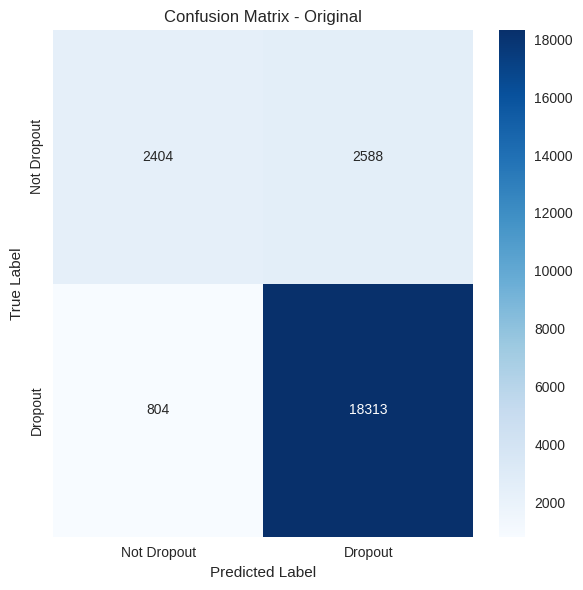

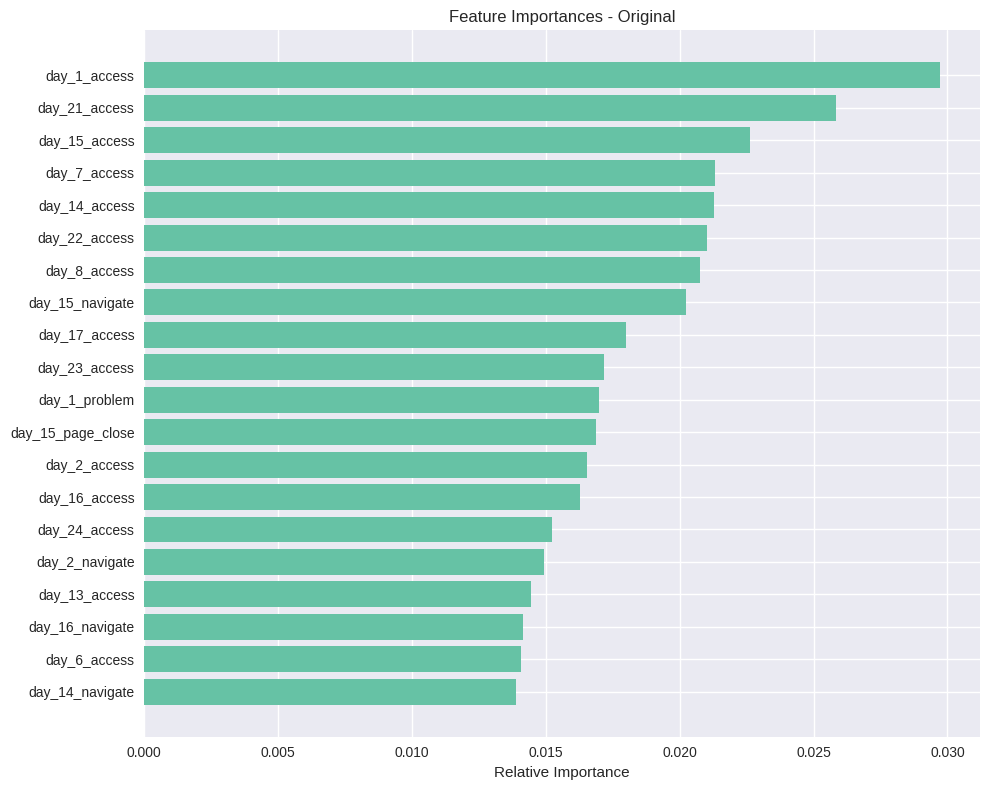


=== Training Random Forest with SMOTE technique ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced Random Forest pipeline with comprehensive hyperparameter tuning,
multiple data balancing techniques (including VAE), and advanced visualizations.
"""

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, classification_report)
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Configuration
# -----------------------------
file_path = 'model1_210_features_spliting.csv'
random_state = 42
test_size = 0.2
n_jobs = -1  # Use all available cores

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

def safe_drop(df: pd.DataFrame, cols):
    """Drop columns if they exist; ignore if not present."""
    return df.drop(columns=[c for c in cols if c in df.columns], errors='ignore')

def plot_correlation_heatmap(corr_df: pd.DataFrame, title: str):
    """Plot a correlation heatmap."""
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, mask=mask, center=0, cmap='RdBu_r', square=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_top_corr_bar(corr_series: pd.Series, top_n: int = 20):
    """Bar chart for top-N correlations with dropout."""
    top_features = corr_series.drop(labels=['dropout'], errors='ignore')
    top_features = top_features.reindex(top_features.abs().sort_values(ascending=False).head(top_n).index)

    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'blue' for x in top_features.values]
    plt.barh(top_features.index, top_features.values, color=colors)
    plt.xlabel('Correlation with dropout')
    plt.ylabel('Feature')
    plt.title(f'Top {min(top_n, len(top_features))} Features Correlated with Dropout')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Dropout', 'Dropout'],
                yticklabels=['Not Dropout', 'Dropout'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(metrics_dict, title='Model Comparison'):
    """Plot bar chart comparing evaluation metrics across models."""
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(roc_data, title='ROC Curves Comparison'):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(8, 6))
    for model_name, data in roc_data.items():
        fpr, tpr, auc_score = data
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curves(pr_data, title='Precision-Recall Curves'):
    """Plot Precision-Recall curves for multiple models."""
    plt.figure(figsize=(8, 6))
    for model_name, data in pr_data.items():
        precision, recall, _ = data
        plt.plot(recall, precision, label=model_name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importances(feature_importances, feature_names, top_n=20, title='Feature Importances'):
    """Plot top N feature importances."""
    indices = np.argsort(feature_importances)[::-1][:top_n]

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), feature_importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def create_vae_sampler(X, latent_dim=10, epochs=50, batch_size=32):
    """Create a Variational Autoencoder for generating synthetic samples."""
    # Normalize data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    original_dim = X_scaled.shape[1]

    # Encoder
    inputs = Input(shape=(original_dim,))
    h = Dense(128, activation='relu')(inputs)
    h = Dense(64, activation='relu')(h)

    # Latent space
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(64, activation='relu')
    decoder_h2 = Dense(128, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')

    h_decoded = decoder_h(z)
    h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded2)

    # VAE model
    vae = Model(inputs, x_decoded_mean)

    # Loss function
    reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, x_decoded_mean)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    # Train VAE
    vae.fit(X_scaled, X_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

    # Create sampler from the decoder
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded2)
    generator = Model(decoder_input, _x_decoded_mean)

    def vae_sampler(n_samples):
        # Generate random points in latent space
        z_samples = np.random.normal(size=(n_samples, latent_dim))
        # Decode to generate samples
        generated = generator.predict(z_samples, verbose=0)
        # Inverse transform to original scale
        return scaler.inverse_transform(generated)

    return vae_sampler

def apply_vae_oversampling(X, y, target_class, n_samples):
    """Apply VAE-based oversampling for the target class."""
    X_target = X[y == target_class]
    vae_sampler = create_vae_sampler(X_target)
    X_synthetic = vae_sampler(n_samples)
    y_synthetic = np.array([target_class] * n_samples)
    return X_synthetic, y_synthetic

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics and predictions."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

    # ROC curve data if probabilities are available
    roc_data = None
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        roc_data = (fpr, tpr, auc_score)

    # Precision-Recall curve data
    pr_data = None
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_data = (precision, recall)

    print(f"\n=== {model_name} Test Metrics ===")
    print(f"Accuracy : {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall   : {metrics['Recall']:.4f}")
    print(f"F1 Score : {metrics['F1 Score']:.4f}")
    print("-" * 50)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Dropout', 'Dropout']))

    return metrics, y_pred, roc_data, pr_data

def main():
    # -----------------------------
    # Load data
    # -----------------------------
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Could not find '{file_path}'. Put the CSV next to this script or update file_path.")

    data = pd.read_csv(file_path)

    # Drop non-feature text IDs if present
    data = safe_drop(data, ['username', 'course_id', 'enrollment_id'])

    # Basic NA handling (adjust as needed)
    data = data.fillna(0)

    # Ensure `dropout` exists
    if 'dropout' not in data.columns:
        raise KeyError("Column 'dropout' not found in the dataset. Please ensure it exists in the CSV.")

    # -----------------------------
    # Correlation analysis
    # -----------------------------
    numeric_df = data.select_dtypes(include=[np.number])
    corr_full = numeric_df.corr()

    if 'dropout' in corr_full.columns:
        corr_with_dropout = corr_full['dropout'].sort_values(ascending=False)
        print("\n=== Correlation of each feature with 'dropout' (descending) ===")
        print(corr_with_dropout.to_string())

        # Plot bar of top correlated with dropout
        plot_top_corr_bar(corr_with_dropout, top_n=20)

        # Heatmap on top-30 absolute correlations
        top_cols = corr_with_dropout.abs().sort_values(ascending=False).head(31).index.tolist()
        sub_corr = corr_full.loc[top_cols, top_cols]
        plot_correlation_heatmap(sub_corr, title="Correlation Heatmap (Top 30 by |corr with dropout|)")
    else:
        print("Warning: 'dropout' not in correlation matrix. Skipping correlation plots.")

    # -----------------------------
    # Prepare data
    # -----------------------------
    X = data.drop(columns=['dropout'])
    y = data['dropout']
    feature_names = X.columns.tolist()

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Store original data for comparison
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # -----------------------------
    # Define models and techniques to compare
    # -----------------------------
    techniques = {
        'Original': (X_scaled, y),
        'SMOTE': None,
        'ADASYN': None,
        'Undersampling': None,
        'Class Weight': None,
        'VAE': None
    }

    # Prepare data for each technique
    X_train_dict = {}
    y_train_dict = {}

    # Original data (no balancing)
    X_train_dict['Original'], X_test, y_train_dict['Original'], y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # SMOTE
    smote = SMOTE(random_state=random_state)
    X_smote, y_smote = smote.fit_resample(X_scaled, y)
    X_train_dict['SMOTE'], _, y_train_dict['SMOTE'], _ = train_test_split(
        X_smote, y_smote, test_size=test_size, random_state=random_state, stratify=y_smote
    )

    # ADASYN
    adasyn = ADASYN(random_state=random_state)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_scaled, y)
    X_train_dict['ADASYN'], _, y_train_dict['ADASYN'], _ = train_test_split(
        X_adasyn, y_adasyn, test_size=test_size, random_state=random_state, stratify=y_adasyn
    )

    # Undersampling
    rus = RandomUnderSampler(random_state=random_state)
    X_rus, y_rus = rus.fit_resample(X_scaled, y)
    X_train_dict['Undersampling'], _, y_train_dict['Undersampling'], _ = train_test_split(
        X_rus, y_rus, test_size=test_size, random_state=random_state, stratify=y_rus
    )

    # Class Weight (we'll use the original data but with class weights)
    X_train_dict['Class Weight'] = X_train_dict['Original']
    y_train_dict['Class Weight'] = y_train_dict['Original']

    # VAE Oversampling
    # Apply VAE only to the training data to avoid data leakage
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Scale training and test data separately
    scaler_vae = StandardScaler()
    X_train_scaled_vae = scaler_vae.fit_transform(X_train_orig)
    X_test_scaled_vae = scaler_vae.transform(X_test_orig)

    # Apply VAE oversampling to the minority class
    n_minority = sum(y_train_orig == 1)
    n_majority = sum(y_train_orig == 0)
    n_samples_needed = n_majority - n_minority

    if n_samples_needed > 0:
        X_synthetic, y_synthetic = apply_vae_oversampling(
            X_train_scaled_vae, y_train_orig, 1, n_samples_needed
        )

        # Combine with original training data
        X_vae = np.vstack([X_train_scaled_vae, X_synthetic])
        y_vae = np.hstack([y_train_orig, y_synthetic])

        X_train_dict['VAE'], _, y_train_dict['VAE'], _ = train_test_split(
            X_vae, y_vae, test_size=test_size, random_state=random_state, stratify=y_vae
        )
    else:
        X_train_dict['VAE'] = X_train_scaled_vae
        y_train_dict['VAE'] = y_train_orig

    # Update X_test and y_test for VAE
    X_test_dict = {k: X_test for k in techniques}
    X_test_dict['VAE'] = X_test_scaled_vae
    y_test_dict = {k: y_test for k in techniques}
    y_test_dict['VAE'] = y_test_orig

    # -----------------------------
    # Hyperparameter tuning for Random Forest
    # -----------------------------
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'bootstrap': [True, False],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }

    # Store best models and results
    best_models = {}
    all_metrics = {}
    all_roc_data = {}
    all_pr_data = {}

    for technique in techniques:
        print(f"\n=== Training Random Forest with {technique} technique ===")

        X_train = X_train_dict[technique]
        y_train = y_train_dict[technique]

        # For class weight technique, compute class weights
        if technique == 'Class Weight':
            class_weights = compute_class_weight(
                'balanced', classes=np.unique(y_train), y=y_train
            )
            class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
            param_dist['class_weight'] = [class_weight_dict]
        else:
            param_dist['class_weight'] = [None]

        # Initialize Random Forest
        rf = RandomForestClassifier(random_state=random_state, n_jobs=n_jobs)

        # RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=50,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state),
            random_state=random_state,
            n_jobs=n_jobs,
            verbose=1,
            scoring='f1'
        )

        # Fit the model
        random_search.fit(X_train, y_train)

        # Get the best model
        best_model = random_search.best_estimator_
        best_models[technique] = best_model

        print(f"Best parameters for {technique}:")
        print(random_search.best_params_)

        # Evaluate the model
        metrics, y_pred, roc_data, pr_data = evaluate_model(
            best_model, X_test_dict[technique], y_test_dict[technique], f"Random Forest with {technique}"
        )

        all_metrics[technique] = metrics
        all_roc_data[technique] = roc_data
        all_pr_data[technique] = pr_data

        # Plot confusion matrix
        plot_confusion_matrix(
            y_test_dict[technique], y_pred,
            title=f'Confusion Matrix - {technique}'
        )

        # Plot feature importances
        if hasattr(best_model, 'feature_importances_'):
            plot_feature_importances(
                best_model.feature_importances_,
                feature_names,
                title=f'Feature Importances - {technique}'
            )

    # -----------------------------
    # Compare all techniques
    # -----------------------------
    plot_metrics_comparison(all_metrics, title='Model Performance Comparison')

    # Plot ROC curves
    plot_roc_curves(all_roc_data, title='ROC Curves Comparison')

    # Plot Precision-Recall curves
    plot_precision_recall_curves(all_pr_data, title='Precision-Recall Curves Comparison')

    # -----------------------------
    # Select and save the best model
    # -----------------------------
    # Find the best technique based on F1 score
    best_technique = max(all_metrics, key=lambda k: all_metrics[k]['F1 Score'])
    best_model = best_models[best_technique]

    print(f"\nBest technique: {best_technique}")
    print(f"Best F1 Score: {all_metrics[best_technique]['F1 Score']:.4f}")

    # Save the best model
    model_filename = f'best_random_forest_model_{best_technique.lower().replace(" ", "_")}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"Best model saved as {model_filename}")

    # Save the scaler
    joblib.dump(scaler, 'scaler.pkl')
    print("Scaler saved as scaler.pkl")

    # -----------------------------
    # SHAP Analysis for the best model
    # -----------------------------
    print(f"\nRunning SHAP analysis for best model ({best_technique})...")
    try:
        # Create SHAP explainer
        explainer = shap.TreeExplainer(best_model)

        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test_dict[best_technique])

        # Summary plot
        plt.figure()
        shap.summary_plot(shap_values[1], X_test_dict[best_technique], feature_names=feature_names, show=False)
        plt.title(f"SHAP Summary Plot - {best_technique}")
        plt.tight_layout()
        plt.show()

        # Force plot for first observation
        plt.figure()
        shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_dict[best_technique][0,:],
                        feature_names=feature_names, matplotlib=True, show=False)
        plt.title(f"SHAP Force Plot for First Observation - {best_technique}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP visualization failed: {str(e)}")

    # -----------------------------
    # LIME Analysis for the best model
    # -----------------------------
    print(f"\nRunning LIME analysis for best model ({best_technique})...")
    try:
        # Create LIME explainer
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train_dict[best_technique],
            feature_names=feature_names,
            class_names=['Not Dropout', 'Dropout'],
            mode='classification',
            random_state=random_state
        )

        # Explain a random instance
        idx = np.random.randint(0, X_test_dict[best_technique].shape[0])
        exp = explainer.explain_instance(
            X_test_dict[best_technique][idx],
            best_model.predict_proba,
            num_features=10,
            top_labels=1
        )

        # Plot LIME explanation
        plt.figure()
        exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Observation {idx} - {best_technique}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"LIME visualization failed: {str(e)}")

if __name__ == '__main__':
    main()